## **Argentina heatwaves**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

### **Pre-processing**

#### **Construct mask for region of interest**

In [ ]:
from xrspatial.experimental import polygonize
from shapely.geometry import Polygon

# load ERA5 geopotential data
gp = xr.open_dataset("../90_data/era5_geopotential.nc").squeeze(drop = True).z

# mask off Argentina only
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(gp.longitude, gp.latitude).sel(region = 9)

# find areas within Argentina with geopotential < 20000
rm = rm.where(rm).where(gp < 20000).dropna("latitude", "all").dropna("longitude", "all").sel(latitude = slice(None, -40))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CONVERT TO POLYGON

# define affine transform to correct coordinates
res = 0.25
transform = np.array([res,0,rm.longitude.min().values - res/2,0,-res,rm.latitude.max().values + res/2])

# convert xarray data to polygon, remove any interior holes
rm_poly = polygonize(rm, mask = rm == 1, return_type = "geopandas", transform = transform).set_crs(epsg = "4326")
rm_poly["geometry"] = rm_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))

# extract points from polygon
rm_px = rm_poly["geometry"].apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SAVE

# save as shapefile, csv & regionmask
rm_poly.to_file("study-region_AR-heatwaves")
rm_px.to_csv("study-region_AR-heatwaves.csv", sep = " ", index = False)
rm.to_netcdf("study-region_AR-heatwaves.nc")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONFIRM

# check that these are all capturing the same area
rm.plot()
ax = plt.gcf().axes[0]
rm_poly.boundary.plot(ax = ax, color = "red")
ax.plot(rm_px.x, rm_px.y, color = "k", ls = "--")

#### **ERA5 time series**

In [ ]:
# era5 hourly to daily
era5 = xr.open_dataset("data/era5_2022_hourly_AR.nc").sortby("time")

mx2t = convert_units_to(era5.mx2t.mean("expver"), "degC").resample(time = "D").max()
mn2t = convert_units_to(era5.mn2t.mean("expver"), "degC").resample(time = "D").min()
t2m = convert_units_to(era5.t2m.mean("expver"), "degC").resample(time = "D").mean()

xr.Dataset(data_vars = {"mx2t" : mx2t, "mn2t" : mn2t, "t2m" : t2m}).to_netcdf("data/era5_2022_daily_AR.nc")

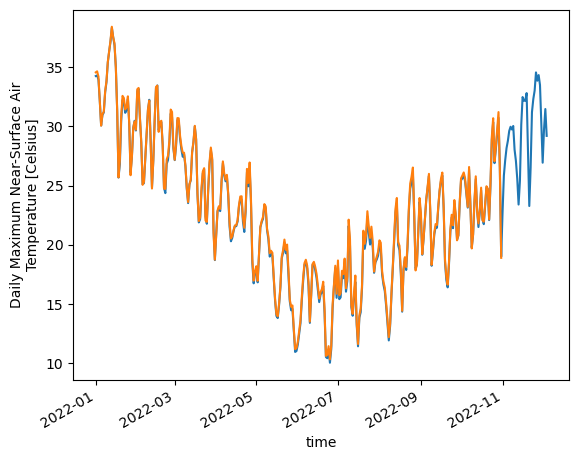

In [2]:
# merge 2022 latest data with Climate Explorer time series
era5 = xr.open_dataset("data/era5_2022_daily_AR.nc").mx2t
sf = gpd.read_file("study-region_AR-heatwaves")
rm = regionmask.mask_3D_geopandas(sf, era5.longitude, era5.latitude).squeeze(drop = True)
era5_2022 = era5.where(rm).dropna("latitude", "all").dropna("longitude", "all")

era5_hist = xr.open_dataset("data/iera5_tmax_daily_mask6_5lan_su.nc").tmax.dropna("time", "any")
era5_2022_ts = era5_2022.mean(["latitude", "longitude"])

era5_ts = xr.concat([era5_hist, era5_2022_ts.sel(time = slice(era5_hist.time.max()+1, None))], "time")
era5_ts.to_netcdf("data/era5_daily_ts.nc")

# visual check that the two time series do match
era5_2022_ts.plot()
era5_hist.sel(time = "2022").plot()

In [ ]:
# load station locations
stations = []
for fnm in glob.glob("data/xgdcnAR*.nc"):
    ds = xr.open_dataset(fnm)
    stations.append([ds.attrs[k] for k in ["station_code", "station_name", "longitude", "latitude"]])
stations = pd.DataFrame(stations, columns = ["station_code", "station_name", "longitude", "latitude"]).set_index("station_code")
stations["longitude"] = [float(l.split(" ")[1]) for l in stations.longitude]
stations["latitude"] = [float(l.split(" ")[1]) for l in stations.latitude]

In [ ]:
fig, axs = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
era5_2022.sel(time = "2022-01-02").plot(ax = axs, cmap = "Reds")
axs.coastlines()
axs.add_feature(cartopy.feature.BORDERS)

axs.scatter(stations.longitude, stations.latitude, marker = "x", color = "k")
axs.axhline(-40, ls = "--", color = "k")

# sf.boundary.plot(ax = axs, color = "k", lw = 0.5)

#### **CPC time series**

In [ ]:
sf = gpd.read_file("study-region_AR-heatwaves")

cpc = []
for fnm in sorted(glob.glob("../03_cpc/tmax/*.nc")):
    
    tmax = xr.open_dataset(fnm).tmax.sel(lon = slice(285,310), lat = slice(-20,-42)).load()
    rm = regionmask.mask_3D_geopandas(sf, tmax.lon, tmax.lat).squeeze(drop = True)
    
    tmax = tmax.where(rm).dropna("lat", "all").dropna("lon", "all")
    cpc.append(tmax)

cpc = xr.concat(cpc, "time")
cpc.to_netcdf("data/cpc_daily.nc")

In [ ]:
cpc = xr.open_dataset("data/cpc_daily.nc").tmax
era5 = xr.open_dataset("data/era5_daily_ts.nc").tmax

In [ ]:
cpc.mean(["lat", "lon"]).sel(time = slice("2022-11", None)).plot()
era5.sel(time = slice("2022-11", None)).plot()

In [ ]:
(cpc.mean(["lat", "lon"]) - era5).sel(time = "2022").plot()
plt.axhline((cpc.mean(["lat", "lon"]) - era5).sel(time = "2022").mean(), ls = "--", color = "darkred")

In [ ]:
ndays = 7
cpc_ann = cpc.rolling(time = ndays).mean().mean(["lat", "lon"]).resample(time = "AS-JUL").max()
era5_ann = era5.rolling(time = ndays).mean().resample(time = "AS-JUL").max().sel(time = cpc_ann.time)

plt.step(cpc_ann.time, cpc_ann - era5_ann)
plt.axhline((cpc_ann - era5_ann).sel(time = slice(None, "2021")).mean(), color = "darkred", ls = "--")

plt.title("Difference between CPC & ERA5 "+str(ndays)+"-day maximum")

---
### **Observed trends in distribution**

In [ ]:
gmst = pd.read_csv("../90_data/gmst.csv", index_col = "year")
era5 = xr.open_dataset("data/era5_daily_ts.nc").tmax
cpc = xr.open_dataset("data/cpc_daily.nc").tmax.mean(["lat", "lon"])

In [ ]:
# compute annual maxima of n-day rolling mean
def nday_max(da, n = 1, return_df = True):
    
    da_max = da.rolling(time = n).mean().resample(time = "AS-JUN").max()
    da_max = da_max.assign_coords(time = da_max.time.dt.year)
    
    if return_df:
        return pd.merge(gmst, da_max.to_dataframe(), how = "inner", left_index = True, right_index = True)
    else:
        return da_max

for n in [1,3,5,7,9]:
    
    nday_max(era5, n)[["tmax"]].to_csv("era5_"+str(n)+"-day-max.txt", sep = " ", header = False)
    nday_max(cpc, n)[["tmax"]].to_csv("cpc_"+str(n)+"-day-max.txt", sep = " ", header = False)

In [ ]:
# ! bash check-obs-fit_wrapper.sh   # to run analysis on climate explorer

---
#### **Provisional estimation of model fit & return periods**

ERA5 does not yet cover the 2022 December heatwave, while CPC only has data from 1979. However, fitted models for CPC and ERA5 for the period from 1979 onwards have very similar parameters, suggesting that the two sources of information are consistent with regards to temperature extremes.

There is a relatively stable offset between CPC and ERA5, with CPC's annual maximum 7-day temperatures around 1.25deg higher than those in ERA5. We therefore subtract 1.25deg from the CPC event value to obtain an approximate expected event value for ERA5, and use this to provisionally estimate the appropriate return period for the event in the ERA5 data.

In [ ]:
def load_ests(fnm):
    
    df = pd.read_csv(fnm, sep = " ", skiprows = 1)
    df.index = [r[3]+"_"+r[1] for r in df.run.str.split("_")]

    return df[["rv"] + [c for c in df.columns if "est" in c]].sort_index()

In [ ]:
df_all = load_ests("cx/check-fit_2022-event.txt")
df_1979 = load_ests("cx/check-fit_2022-event_from-1979.txt")
df_1979["fit_type"] = [s+"_1979" for s in df_1979.index]
df_1979 = df_1979.set_index("fit_type")
df_1979 = df_1979.loc[df_1979.index.str.contains("era5")]
df = pd.concat([df_all, df_1979, pd.read_csv("cx/check-fit_2022-era-inferred.txt", index_col = "fit_type")])

In [ ]:
df.loc[df.index.str.contains("7day")]